# 6장 모델튜닝 
## 6.1 매개변수 튜닝 
## 6.1.1 하이퍼파라미터 탐색 방법 
### 1) 수동으로 매개변수 조정 
#### - 의미없는 특징이 많이 쓰이면, regularization사용하여 중요한 매개변수 사용 
#### - 상호작용의 반영이 부족하면, 결정트리의 분기수를 증가시킴
#### - 작업자의 튜닝시간이 꽤 걸리나, 톱클래스 캐글러는 수동으로 매개변수 조정.

### 2) 그리드 서치와 랜덤 서치 
###  그리드 서치(Grid Search)
- 매개변수와 각 매개변수의 범위를 지정하여 탐색. 
- 조합에 따른 탐색점(search point) 수가 많아질 수 있음. 

###  랜덤 서치(Random Search)
- 매개변수와 각 매개변수의 범위를 정하고 랜덤하게 설정한 횟수만큼 반복하여 선택한 조합을 만듬. 
- 매개변수의 범위를 일정한 값이 아니라, 분포로 지정할수도 있음(일정한 범위의 균등분포도 가능). 
- 단 모든 조합을 탐색하지 못할 수도 있음. 

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from IPython.display import Image

In [2]:
iris = datasets.load_iris()

param_grid = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(iris.data, iris.target)
print(clf.cv_results_['params'])
print(clf.cv_results_['mean_test_score'])


[{'C': 1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'rbf'}, {'C': 10, 'kernel': 'linear'}, {'C': 10, 'kernel': 'rbf'}]
[0.98       0.96666667 0.97333333 0.98      ]


In [3]:
# LMS Exploration 6-11 
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    # param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    # scoring : 모델의 성능을 평가할 지표
    # cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    # verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    # n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### 베이즈 최적화(Bayesian Optimization)
- 이전에 계산된 "매개변수의 이력에 근거"하여 다음에 탐색할 매개변수를 베이즈 확률로 선택하는 방법
- 랜덤서치에서는 전혀 성능이 나오지 않았던 매개변수 주변도 탐색. 
- 라이브러리: hyperopt, optuna
- 쉽게 이해하고 싶을때는 그리드 서치, 성능이 필요할때는 베이즈 최적화.  랜덤서치 방법의 이용이 제한적임. 

## 6.1.2 매개변수 튜닝으로 설정
- 1) 베이스라인이 될 매개변수 
- 2) 탐색대상이 될 매개변수와 범위 : 모델초기값은 무난한 값(속도와 단순함) 
- 3) 수동 조정할지 자동 탐색할지 여부: 중요한 매개변수위주/베이즈최적화
- 4) 평가시스템(교차검증 등 폴드분할방법) : 매개변수 튜닝시의 폴드분할시드와 모델예측에서 사용하는 폴드분할시드는 다른값사용



## 6.1.3 매개변수 튜닝의 포인트
- 중요한 매개변수 부터 조정
- 매개변수 값을 증가할 때, 모델의 복잡성을 증가시키는 매개변수와 감소시키는 매개변수가 있음. 
- 매개변수의 범위 상단 또는 하단에 좋은 점수 결과가 있다면, 좀 더 범위를 넓혀서 탐색.
- 학습시에는 난수 시드를 고정하여 이용. 
- 매개변수 변경으로 인한 성과개선과 랜덤적 성과개선을 구별(모델 난수시드, 폴드분할 난수시드)

## 6.1.4 베이즈 최적화에서의 매개변수 탐색
### 성능향상을 위한 좋은 선택이지만, 단점도 있음 
#### - 계산 시간이 오래걸리는 점
#### - 매개변수 간 의존성으로 인한 탐색효율성 저하  (시행횟수 증가로 극복)
#### - 평가의 랜덤성에 따른 편차  (평균값평가, 시행횟수 증가로 극복)

### hyperopt 
- 베이즈 최적화 라이브러리 중에 가장 자주 쓰임
- TPE(tree-structured parzen estimator)알고리즘으로 계산 (가오시안프로세스이용 알고리즘은 속도느려서 사용x) 
- 1) 최소화하고 싶은 평가지표 설정 -> 2) 탐색할 매개변수 범위정의(사전분포prior distribution:선택지/균등분포/로그균등분포) -> 탐색횟수 지정(100번정도사용)
- 코드예시 fmin(score,space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

## (실습) https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/09-lightgbm-hyperopt.ipynb

### optuna
- 2018년 공개된 프레임워크로 TPE를 사용 
- API사용이 편리하고(API단순화) 효율적으로 튜닝.
- 병렬 분산 최적화
- 학습 곡선을 이용한 시행의 가지치기
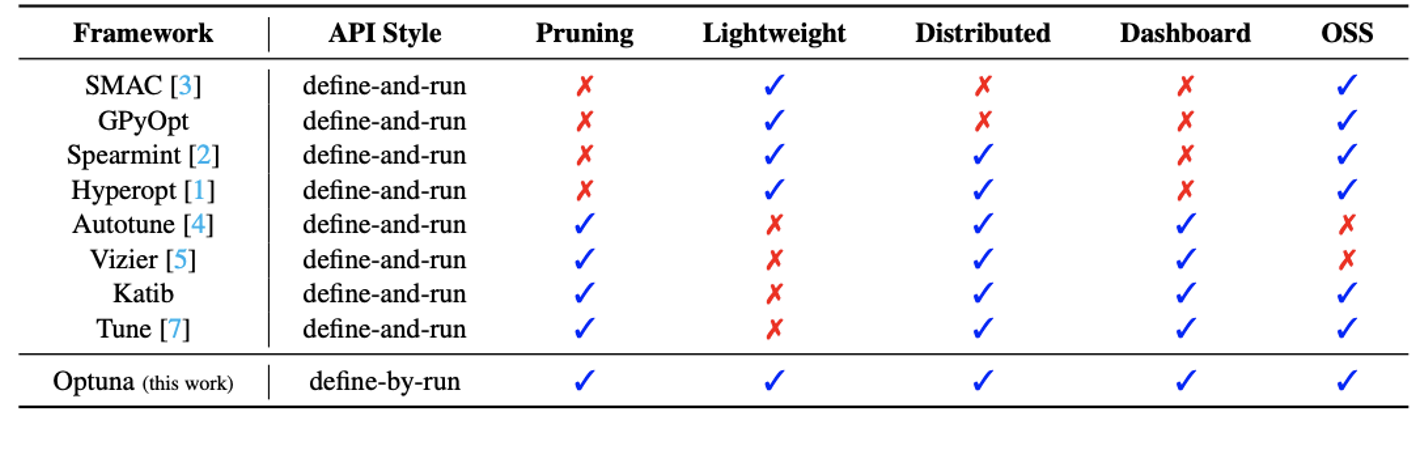

- 최적의 파라미터를 손쉽게 알려주는 기능(제공되는 ML모델들이 있음) 
- 코드예시: import optuna.integration.lightgbm as lgb
- Search Space를 스스로 지정하여 최적화 parameter를 리턴(customize범위가 제한적임)

## (실습) https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/09-lightgbm-optuna.ipynb

(참고영상) https://youtu.be/6cUlsqYFZEE